In [40]:
#EV_station_optimization
#Lingcai Yuan - 08/24/2024
import pandas as pd
import os

# Load the dataset
here = os.getcwd()
input_dir = os.path.abspath(os.path.join(here, os.pardir))
file_path = os.path.join(input_dir, 'ev_charging_station_usage.csv')
data = pd.read_csv(file_path)
# Display basic information about the dataset
data.info(), data.head()
# Print dataset columns
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259415 entries, 0 to 259414
Data columns (total 33 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Station Name                     259415 non-null  object 
 1   MAC Address                      259415 non-null  object 
 2   Org Name                         259415 non-null  object 
 3   Start Date                       259415 non-null  object 
 4   Start Time Zone                  259415 non-null  object 
 5   End Date                         259415 non-null  object 
 6   End Time Zone                    259415 non-null  object 
 7   Transaction Date (Pacific Time)  259206 non-null  object 
 8   Total Duration (hh:mm:ss)        259415 non-null  object 
 9   Charging Time (hh:mm:ss)         259415 non-null  object 
 10  Energy (kWh)                     259415 non-null  float64
 11  GHG Savings (kg)                 259415 non-null  float64
 12  Ga

C:\Users\ericy\AppData\Local\Temp\ipykernel_127172\658401542.py:9: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


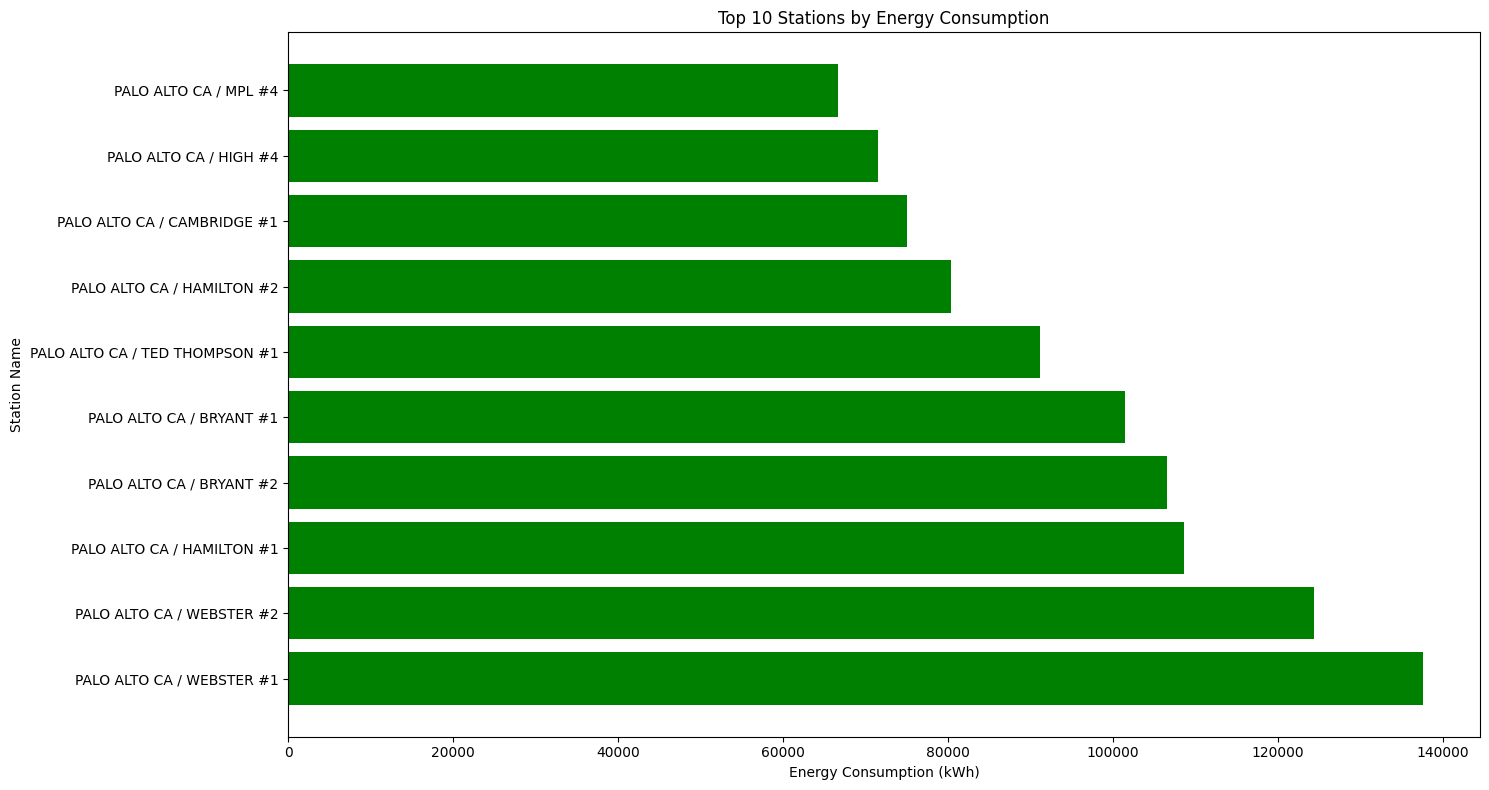

In [41]:
import matplotlib.pyplot as plt

# Convert date columns to datetime for analysis
data['Start Date'] = pd.to_datetime(data['Start Date'], errors='coerce')
data['End Date'] = pd.to_datetime(data['End Date'], errors='coerce')

# Ensure numeric columns are of the correct type
data['Energy (kWh)'] = pd.to_numeric(data['Energy (kWh)'], errors='coerce')

# Group data by station to analyze energy consumption patterns
station_energy_data = data.groupby(['Station Name', 'City', 'Latitude', 'Longitude'], as_index=False)['Energy (kWh)'].sum()

# Sort by energy consumption
station_energy_data = station_energy_data.sort_values(by='Energy (kWh)', ascending=False)

# Plot the top 10 stations by energy consumption
top_stations = station_energy_data.head(10)

plt.figure(figsize=(15, 8))
plt.barh(top_stations['Station Name'], top_stations['Energy (kWh)'], color='green')
plt.xlabel('Energy Consumption (kWh)')
plt.ylabel('Station Name')
plt.title('Top 10 Stations by Energy Consumption')
plt.tight_layout()
plt.show()


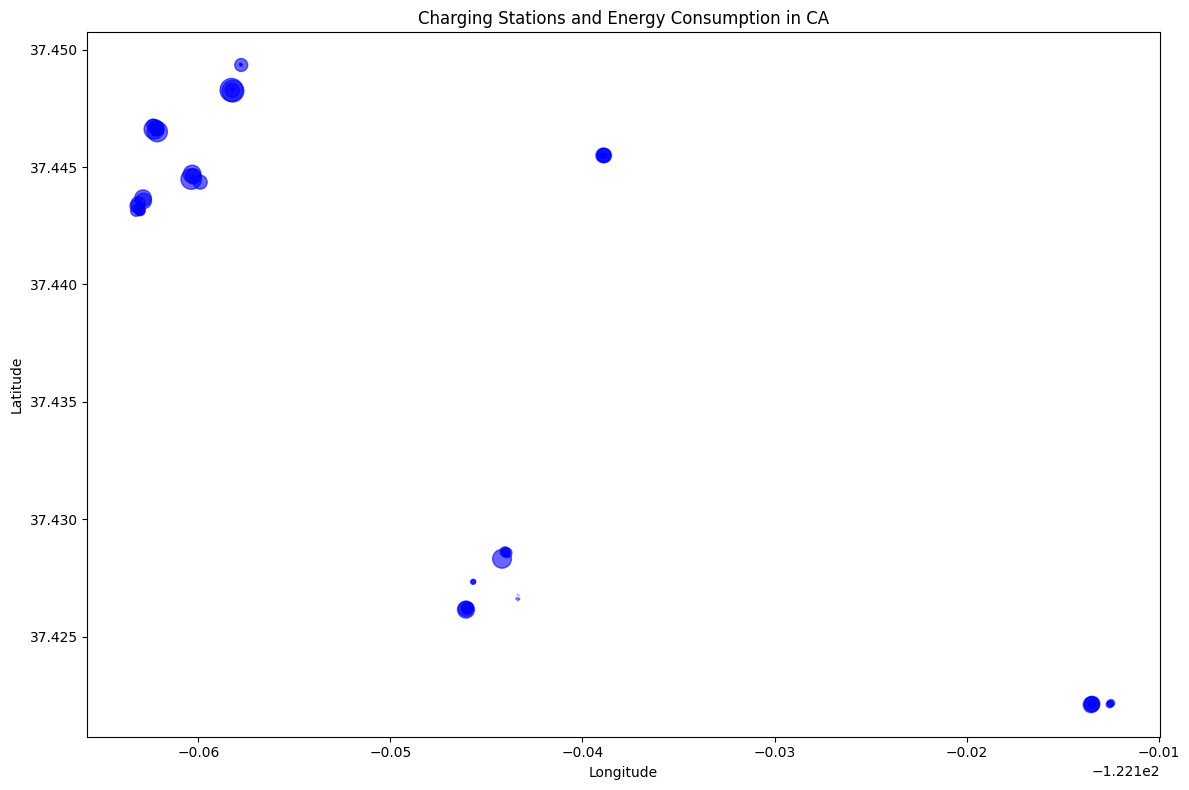

In [42]:
import matplotlib.pyplot as plt
import geopandas as gpd
import geopandas.tools

plt.figure(figsize=(12, 8))
# Ensure valid coordinates
geo_data = gpd.GeoDataFrame(
    station_energy_data,
    geometry=gpd.points_from_xy(station_energy_data['Longitude'], station_energy_data['Latitude'])
)

# Draw a scatter plot based on station locations, sizing points by energy consumption
plt.scatter(geo_data['Longitude'], geo_data['Latitude'], 
            s=geo_data['Energy (kWh)']/500, c='blue', alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Charging Stations and Energy Consumption in CA")
plt.tight_layout()
plt.show()

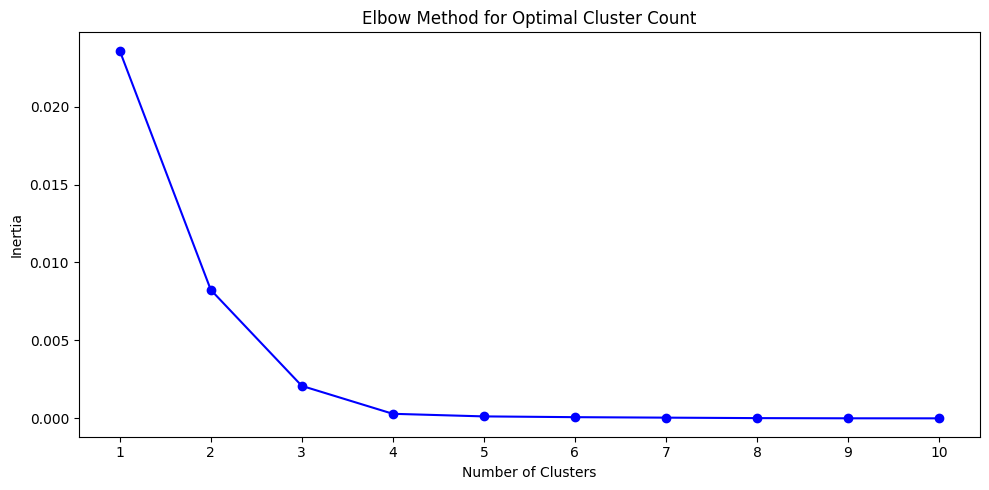

In [43]:
from sklearn.cluster import KMeans
import numpy as np

# Prepare data for clustering
coords = geo_data[['Latitude', 'Longitude']].values

# Determine optimal number of clusters (stations)
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertia.append(kmeans.inertia_)

# Plot the inertia to find the optimal number of clusters
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia, marker='o', color='b')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Cluster Count")
plt.xticks(cluster_range)
plt.tight_layout()
plt.show()

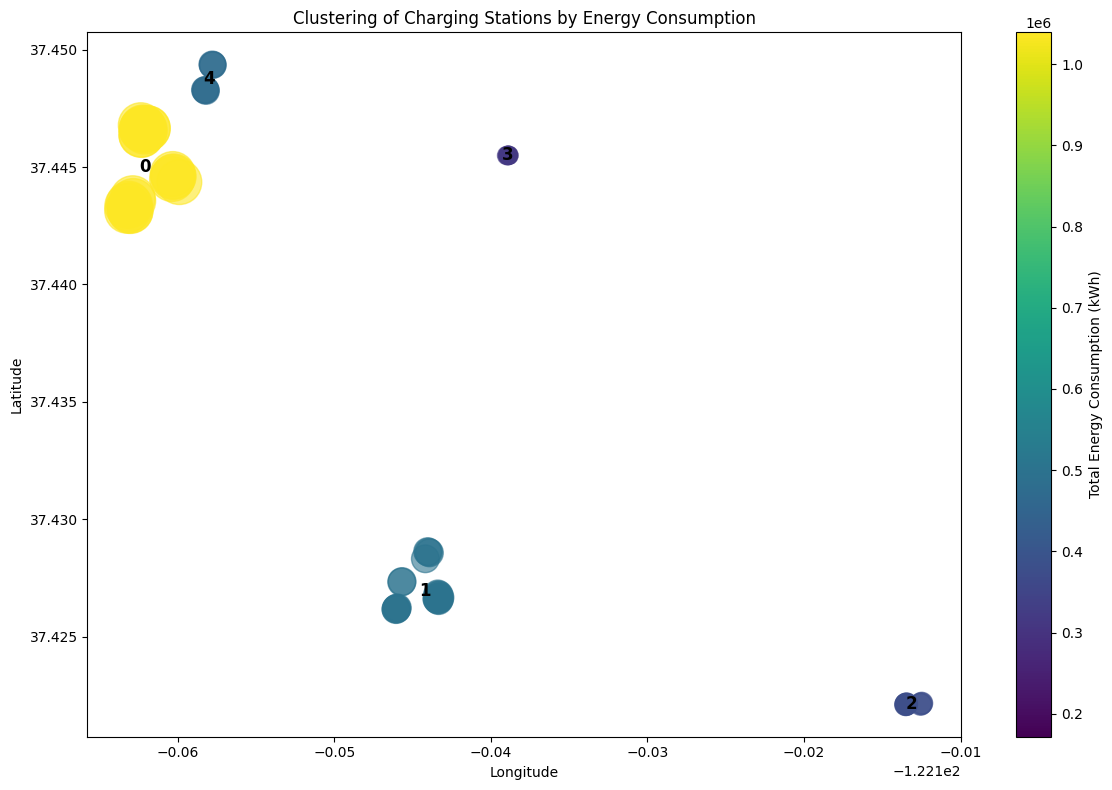

In [44]:
import matplotlib.pyplot as plt
import geopandas as gpd
import geopandas.tools
# Clustering with KMeans
coords = geo_data[['Latitude', 'Longitude']].values
kmeans = KMeans(n_clusters=5, random_state=42)
geo_data['Cluster'] = kmeans.fit_predict(coords)

# Group clusters by total energy consumption
cluster_summary = geo_data.groupby('Cluster', as_index=False).agg({
    'Energy (kWh)': 'sum',
})

# Map cluster IDs to total energy
cluster_energy_map = cluster_summary.set_index('Cluster')['Energy (kWh)'].to_dict()

# Assign color and size based on total energy consumption per cluster
geo_data['Cluster Energy'] = geo_data['Cluster'].map(cluster_energy_map)
geo_data['Color'] = geo_data['Cluster Energy'].apply(lambda x: plt.cm.viridis(x / max(cluster_energy_map.values())))

# Create a scatter plot
plt.figure(figsize=(12, 8))

ax = plt.gca()

sc = ax.scatter(geo_data['Longitude'], geo_data['Latitude'],
            s=geo_data['Cluster Energy'] / 1000, c=geo_data['Color'], alpha=0.6)

# Annotate clusters
for cluster in geo_data['Cluster'].unique():
    cluster_coords = geo_data[geo_data['Cluster'] == cluster]
    avg_longitude = cluster_coords['Longitude'].mean()
    avg_latitude = cluster_coords['Latitude'].mean()
    
    plt.text(avg_longitude, avg_latitude, str(cluster), fontsize=12, ha="center", va="center", weight="bold")

# Color bar mapping energy consumption
norm = plt.Normalize(vmin=min(cluster_energy_map.values()), vmax=max(cluster_energy_map.values()))
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax, label="Total Energy Consumption (kWh)")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clustering of Charging Stations by Energy Consumption")

plt.tight_layout()
plt.show()

In [45]:
from sklearn.cluster import KMeans

# Prepare data for clustering
coords = geo_data[['Latitude', 'Longitude']].values

# Apply KMeans clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
geo_data['Cluster'] = kmeans.fit_predict(coords)

# Now proceed with summarizing
cluster_summary = geo_data.groupby('Cluster', as_index=False).agg({
    'Station Name': 'count',
    'Energy (kWh)': ['sum', 'mean'],
    'Latitude': 'mean',
    'Longitude': 'mean'
})

# Flatten multi-level columns
cluster_summary.columns = ['Cluster', 'Station Count', 'Total Energy (kWh)', 'Average Energy (kWh)', 'Avg Latitude', 'Avg Longitude']

cluster_summary = cluster_summary.sort_values(by='Total Energy (kWh)', ascending=False)

# Display the cluster summary
print(cluster_summary)


   Cluster  Station Count  Total Energy (kWh)  Average Energy (kWh)  \
0        0             25        1.039265e+06          41570.611481   
1        1             24        3.970213e+05          16542.553416   
4        4              7        3.634940e+05          51927.715737   
2        2              8        2.450094e+05          30626.174629   
3        3              6        1.717236e+05          28620.604720   

   Avg Latitude  Avg Longitude  
0     37.445011    -122.162113  
1     37.426930    -122.144224  
4     37.448736    -122.158037  
2     37.422130    -122.113115  
3     37.445496    -122.138910  


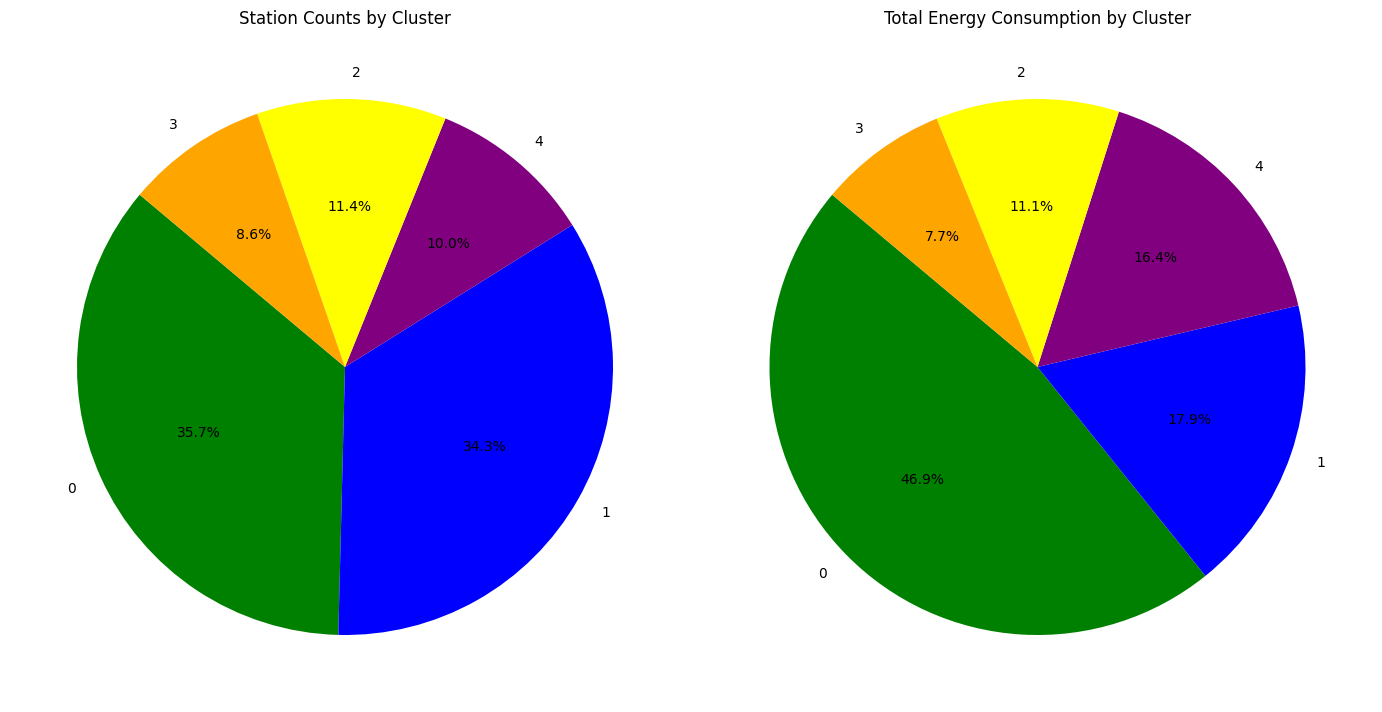

In [46]:
# Visualization using pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Station count pie chart
ax1.pie(cluster_summary['Station Count'], labels=cluster_summary['Cluster'], autopct='%1.1f%%', startangle=140, colors=['green', 'blue', 'purple', 'yellow', 'orange'])
ax1.set_title("Station Counts by Cluster")

# Energy consumption pie chart
ax2.pie(cluster_summary['Total Energy (kWh)'], labels=cluster_summary['Cluster'], autopct='%1.1f%%', startangle=140, colors=['green', 'blue', 'purple', 'yellow', 'orange'])
ax2.set_title("Total Energy Consumption by Cluster")

# Display plots
plt.tight_layout()
plt.show()

In [52]:
#using priority queue to create a scheduling algorithm 
import heapq
from datetime import datetime

# Convert timing columns to datetime and durations
data['Start Date'] = pd.to_datetime(data['Start Date'], errors='coerce')
data['End Date'] = pd.to_datetime(data['End Date'], errors='coerce')
data['Total Duration (hh:mm:ss)'] = pd.to_timedelta(data['Total Duration (hh:mm:ss)'], errors='coerce')
data['Charging Time (hh:mm:ss)'] = pd.to_timedelta(data['Charging Time (hh:mm:ss)'], errors='coerce')

# Drop rows with invalid durations
data = data.dropna(subset=['Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)'])

# Group sessions by station and sort by start time
station_sessions = data.sort_values(by=['Station Name', 'Start Date'])

# Prepare the priority queue
class SessionQueue:
    def __init__(self):
        self.heap = []

    def push(self, station, start_time, charging_time):
        # Push sessions onto the heap, prioritizing by start time
        heapq.heappush(self.heap, (start_time, station, charging_time))

    def pop(self):
        # Pop sessions from the heap
        return heapq.heappop(self.heap)

# Initialize session queues for each station
station_availability = {station: SessionQueue() for station in station_sessions['Station Name'].unique()}

# Populate queues with sessions
for _, session in station_sessions.iterrows():
    station = session['Station Name']
    start_time = session['Start Date']
    charging_time = session['Charging Time (hh:mm:ss)']

    station_availability[station].push(station, start_time, charging_time)

# Schedule sessions by processing each queue
scheduled_sessions = []

for station, queue in station_availability.items():
    while queue.heap:
        start_time, station, charging_time = queue.pop()

        # Calculate end time
        end_time = start_time + charging_time

        scheduled_sessions.append((station, start_time, end_time))

# Display the first 5 scheduled sessions
scheduled_sessions[:5]

[('PALO ALTO CA / BRYANT # 1',
  Timestamp('2020-09-06 11:22:00'),
  Timestamp('2020-09-06 13:02:16')),
 ('PALO ALTO CA / BRYANT # 1',
  Timestamp('2020-09-07 12:51:00'),
  Timestamp('2020-09-07 13:43:09')),
 ('PALO ALTO CA / BRYANT # 1',
  Timestamp('2020-10-13 13:40:00'),
  Timestamp('2020-10-13 15:00:35')),
 ('PALO ALTO CA / BRYANT # 1',
  Timestamp('2020-10-14 09:23:00'),
  Timestamp('2020-10-14 16:35:13')),
 ('PALO ALTO CA / BRYANT # 1',
  Timestamp('2020-10-17 16:22:00'),
  Timestamp('2020-10-17 17:17:51'))]